Partie 1 – Exploration des données

1. Charger les données et afficher les premières lignes du jeu de données.

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

random_state = 42

df = pd.read_csv("donnees_capteurs.csv")
print(df.head())

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0 -0.188261  4.272281 -2.015332  1.389334 -2.244013 -2.661879 -7.893598   
1  0.420700  0.769072 -0.035718 -1.191842 -1.239605 -2.291225 -3.574525   
2 -0.475795  0.536255  1.494485 -0.634437 -1.672664 -0.084484 -2.245697   
3  0.355669  3.432472 -1.034858 -1.417163 -2.986642  0.787260 -1.564566   
4  0.595491 -2.196669  0.161829  0.779237  2.005329  2.469080  1.531925   

   sensor_8  sensor_9  sensor_10  status            timestamp  
0 -5.352922  1.193113  -0.071093       0  2024-01-05 14:00:00  
1 -0.889998 -0.577921  -0.836122       0  2024-01-18 11:00:00  
2 -0.621177 -0.826112  -0.654323       1  2024-01-24 13:00:00  
3 -1.253638  0.191577   1.031987       0  2024-01-04 05:00:00  
4 -1.091795 -0.589895  -0.006695       1  2024-01-08 13:00:00  


2. Étudier la distribution des valeurs pour les capteurs (sensor_1 à sensor_10) et
celle de la variable cible status.

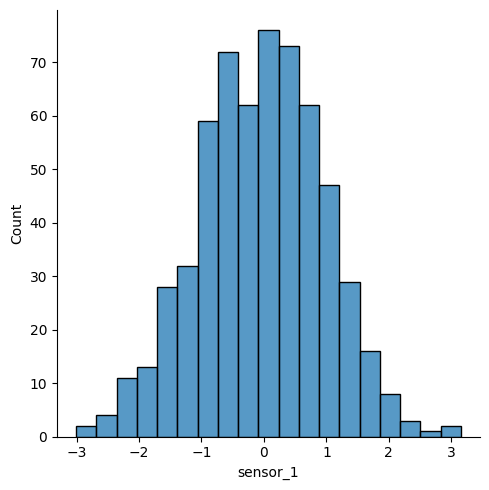

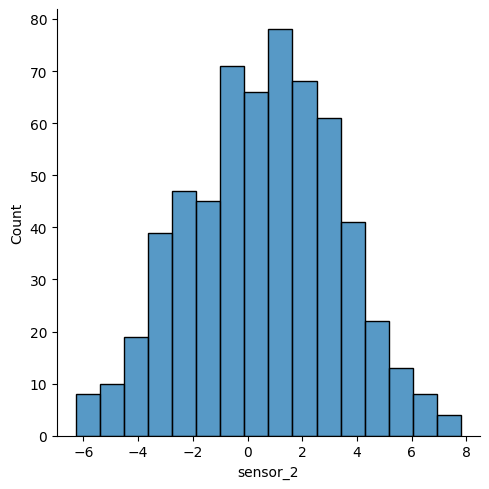

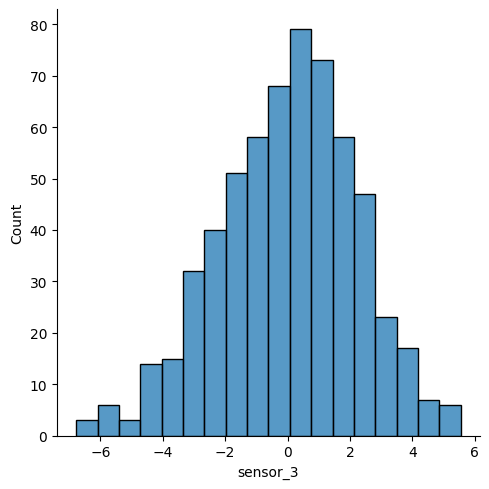

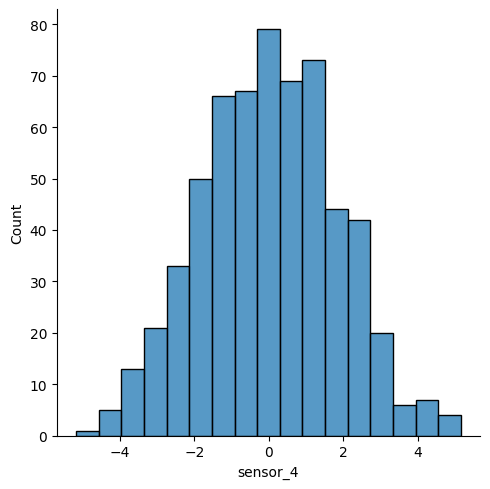

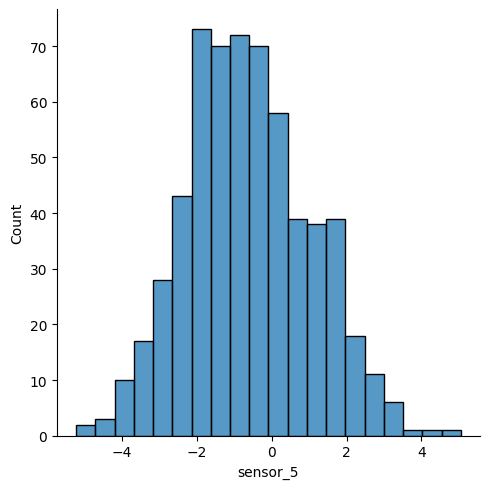

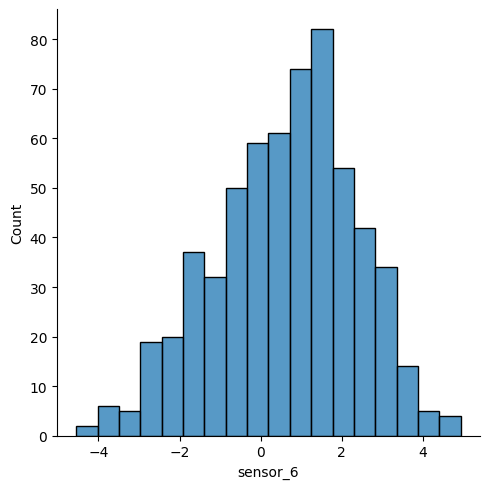

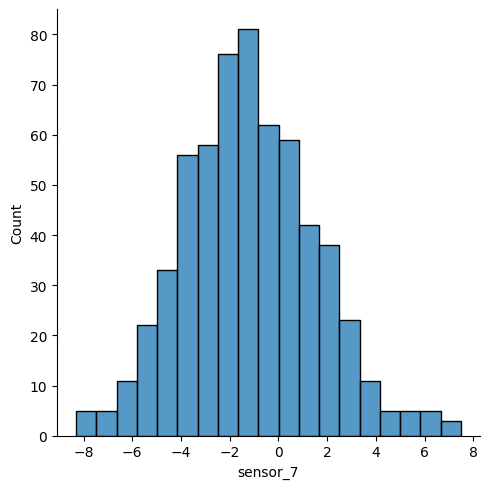

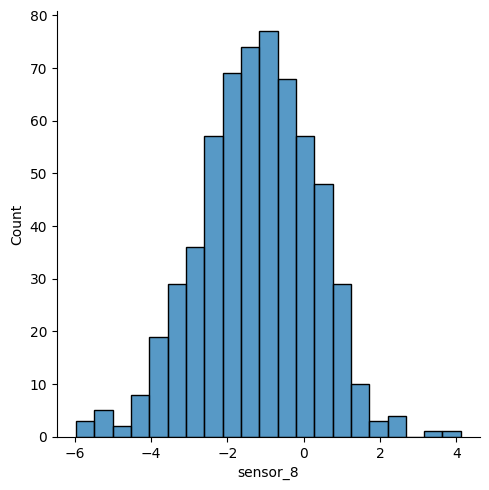

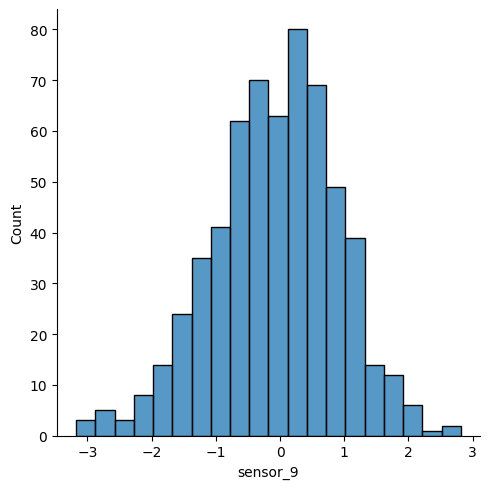

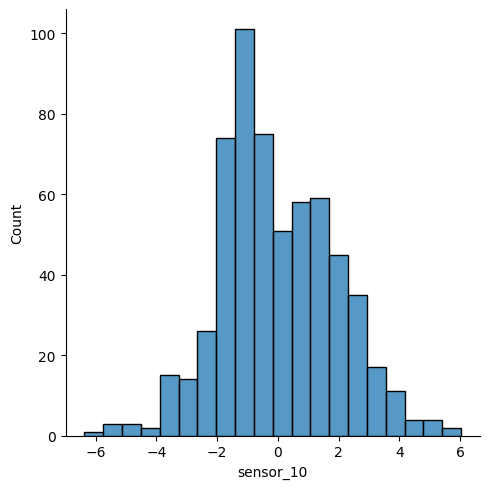

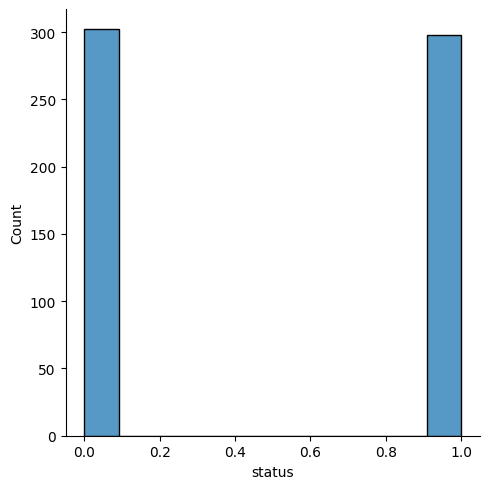

In [47]:
for i in df.iloc[:,:-1]:
  sns.displot(df,x=i)

3. Identifier les corrélations entre variables, et détecter d’éventuelles anomalies.

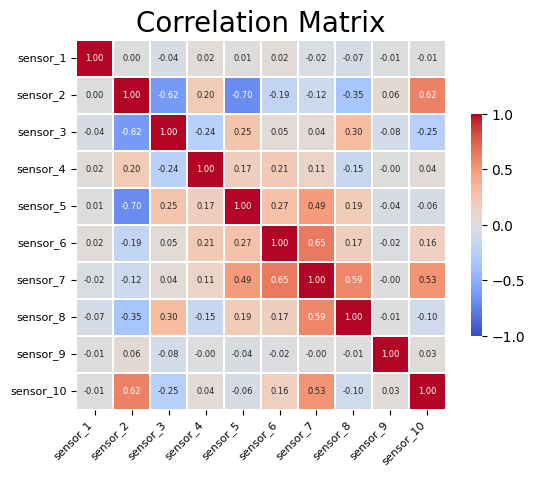

In [48]:
def plot_correlation_matrix(X, columns=None, title="Correlation Matrix"):
    if isinstance(X, pd.DataFrame):
        df = X.copy()
    else:
        if columns is None:
            columns = [f"Feature {i + 1}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=columns)

    sns.heatmap(
        df.corr(),
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        annot_kws={"size": 6},
        square=True,
        linewidths=0.3,
        cbar_kws={"shrink": 0.6},
    )
    plt.title(title, fontsize=20)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-2],
    df.iloc[:, -2],
    test_size=0.2,
    random_state=random_state,
)
plot_correlation_matrix(X_train)

Partie 2 – Prétraitement

4. Traiter les éventuelles valeurs manquantes.
5. Appliquer une normalisation ou une standardisation des données.

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
    StandardScaler,
)
from sklearn.impute import SimpleImputer, KNNImputer

def build_washing_pipeline(X_train, categorical_threshold=10, encoder="ordinal"):
    # Discriminate categorical features and numerical features
    features_categorical = []
    features_numerical = []
    for col in X_train.columns:
        if X_train[col].dtypes == "object":
            features_categorical.append(col)
        else:
            if len(X_train[col].dropna().unique()) < categorical_threshold:
                features_categorical.append(col)
            else:
                features_numerical.append(col)

    # Fill missing values & standardize numerical features
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", KNNImputer()),
            ("scaler", StandardScaler()),
        ]
    )

    # Fill missing values & encode categorical features
    if encoder == "ordinal":
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                (
                    "encoder",
                    OrdinalEncoder(
                        handle_unknown="use_encoded_value", unknown_value=-1
                    ),
                ),
            ]
        )
    elif encoder == "onehot":
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                (
                    "encoder",
                    OneHotEncoder(
                        handle_unknown="ignore", sparse_output=False, drop="first"
                    ),
                ),
            ]
        )
    else:
        raise ValueError("Encoder must be 'ordinal' or 'onehot'")

    transformers = []
    if features_numerical:
        transformers.append(("Num", numeric_transformer, features_numerical))
    if features_categorical:
        transformers.append(("Cat", categorical_transformer, features_categorical))

    return ColumnTransformer(
        transformers=transformers,
        remainder="passthrough",
        verbose_feature_names_out=False,
    ).set_output(transform="pandas")

6. Après une réduction de dimensionnalité, afficher les données en 2D et évaluer la
séparabilité des classes.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


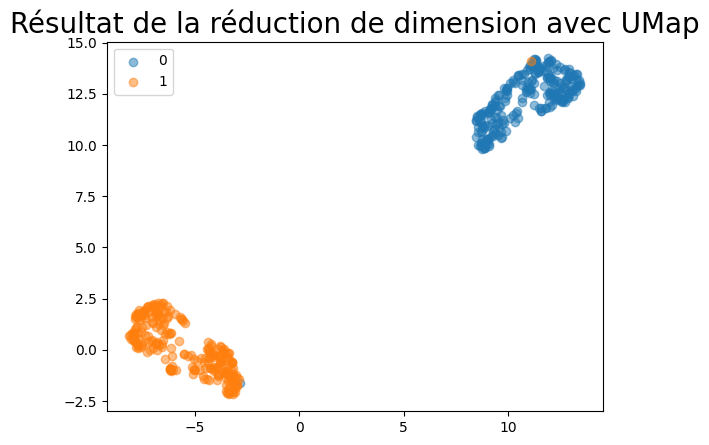

In [50]:
import umap.umap_ as umap

def plot_2D(X, y, target_names, title):
    for i, target_name in enumerate(target_names):
        plt.scatter(
            X[y == i, 0],
            X[y == i, 1],
            label=target_name,
            alpha=0.5,
        )

    plt.legend()
    plt.title(title, fontsize=20)
    plt.show()

pipeline = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train)),
        (
            "dimension_reduction",
            umap.UMAP(
                n_components=2,
                n_jobs=1,
                random_state=random_state,
            ),
        ),
    ]
)

pipeline.fit(X_train, y_train)
X_reduced = pipeline.transform(X_train)
plot_2D(X_reduced, y_train, y_train.unique(), title = "Résultat de la réduction de dimensionnalité avec UMap")

In [51]:
# En utilisant Umap, les données sont bien séparable.

Partie 3 – Modélisation de base

7. Entraîner les modèles suivants :
- Régression logistique
- k-Nearest Neighbors
- Arbre de décision
- Support Vector Machine (SVM)
- Forêt aléatoire (Random Forest)
- Gradient Boosting (XGBoost ou autre)

Pour chaque modèle, utiliser GridSearchCV pour optimiser les hyperparamètres.

In [52]:
from sklearn.model_selection import GridSearchCV
import pprint

def optimize_hyperparameters(X, y, estimator, param_grid):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="accuracy",
        n_jobs=-1,
        cv=5,
        return_train_score=True,
    )
    grid_search.fit(X, y)
    print("Best parameters found:")
    pprint.pp(grid_search.best_params_)
    return grid_search

In [56]:
from sklearn.linear_model import LogisticRegression

pipeline_LR = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train)),
        (
            "dimension_reduction",
            umap.UMAP(
                n_components=2,
                n_jobs=1, # It may take decades because n_jobs has to be 1 when random_state is specified
                random_state=random_state,
            ),
        ),
        ("model", LogisticRegression(random_state=random_state))
    ]
)

param_grid_LR = {
    "model__C": [1.0, 2.0],
    "model__fit_intercept": [True, False],
}

pipeline_LR = optimize_hyperparameters(
    X=X_train,
    y=y_train,
    estimator=pipeline_LR,
    param_grid=param_grid_LR,
).best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters found:
{'model__C': 1.0, 'model__fit_intercept': True}


In [58]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_KNN = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train)),
        (
            "dimension_reduction",
            umap.UMAP(
                n_components=2,
                n_jobs=1,
                random_state=random_state,
            ),
        ),
        ("model", KNeighborsClassifier())
    ]
)

param_grid_KNN = {
    "model__n_neighbors": [3, 5],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan", "minkowski"],
}

pipeline_KNN = optimize_hyperparameters(
    X=X_train,
    y=y_train,
    estimator=pipeline_KNN,
    param_grid=param_grid_KNN,
).best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters found:
{'model__metric': 'euclidean',
 'model__n_neighbors': 3,
 'model__weights': 'uniform'}


In [59]:
from sklearn.tree import DecisionTreeClassifier

pipeline_DT = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train)),
        (
            "dimension_reduction",
            umap.UMAP(
                n_components=2,
                n_jobs=1,
                random_state=random_state,
            ),
        ),
        ("model", DecisionTreeClassifier(random_state=random_state))
    ]
)

param_grid_DT = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", "log2"],
}

pipeline_DT = optimize_hyperparameters(
    X=X_train,
    y=y_train,
    estimator=pipeline_DT,
    param_grid=param_grid_DT,
).best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters found:
{'model__criterion': 'gini',
 'model__max_depth': 10,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 5}


In [60]:
from sklearn.svm import SVC

pipeline_SVM = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train)),
        (
            "dimension_reduction",
            umap.UMAP(
                n_components=2,
                n_jobs=1,
                random_state=random_state,
            ),
        ),
        ("model", SVC(random_state=random_state))
    ]
)

param_grid_SVM = {
    "model__C": [0.01, 1],
    "model__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "model__gamma": ["scale", "auto"],
    "model__degree": [2, 3],
}

pipeline_SVM = optimize_hyperparameters(
    X=X_train,
    y=y_train,
    estimator=pipeline_SVM,
    param_grid=param_grid_SVM,
).best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters found:
{'model__C': 0.01,
 'model__degree': 2,
 'model__gamma': 'scale',
 'model__kernel': 'linear'}


In [62]:
from sklearn.ensemble import RandomForestClassifier

pipeline_RF = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train)),
        (
            "dimension_reduction",
            umap.UMAP(
                n_components=2,
                n_jobs=1,
                random_state=random_state,
            ),
        ),
        ("model", RandomForestClassifier(random_state=random_state))
    ]
)

param_grid_RF = {
    "model__n_estimators": [50, 100],
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [10, 20],
}

pipeline_RF = optimize_hyperparameters(
    X=X_train,
    y=y_train,
    estimator=pipeline_RF,
    param_grid=param_grid_RF,
).best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters found:
{'model__criterion': 'gini', 'model__max_depth': 10, 'model__n_estimators': 100}


In [65]:
from xgboost import XGBClassifier

pipeline_XGB = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train)),
        (
            "dimension_reduction",
            umap.UMAP(
                n_components=2,
                n_jobs=1,
                random_state=random_state,
            ),
        ),
        ("model", XGBClassifier(random_state=random_state))
    ]
)

param_grid_XGB = {
    "model__max_depth": [3, 10],
    "model__gamma": [0, 1],
    "model__learning_rate": [0.01, 0.3],
    "model__n_estimators": [25, 200],
}

pipeline_XGB = optimize_hyperparameters(
    X=X_train,
    y=y_train,
    estimator=pipeline_XGB,
    param_grid=param_grid_XGB,
).best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters found:
{'model__gamma': 0,
 'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 25}


Partie 4 – Évaluation

8. Évaluer les modèles et comparer les performances entre modèles

In [66]:
from sklearn.metrics import classification_report

def plot_classification_report(
    estimator, X_train, y_train, X_test, y_test, title="Classification Report"
):
    report_train = classification_report(
        y_train, estimator.predict(X_train), output_dict=True
    )
    report_test = classification_report(
        y_test, estimator.predict(X_test), output_dict=True
    )

    df_train = pd.DataFrame(report_train).T
    df_test = pd.DataFrame(report_test).T

    df_combined = pd.concat(
        [df_train, df_test],
        axis=1,
        keys=["Train", "Test"],
    )

    idx = df_combined.index.get_loc("accuracy")
    df_combined = pd.concat(
        [
            df_combined.iloc[:idx],
            pd.DataFrame(
                [[np.nan] * len(df_combined.columns)],
                columns=df_combined.columns,
                index=["\u200b"],
            ),
            df_combined.iloc[idx:],
        ]
    )

    for t1 in ["Train", "Test"]:
        for t2 in ["precision", "recall"]:
            df_combined.at["accuracy", (t1, t2)] = np.nan
        df_combined.at["accuracy", (t1, "support")] = df_combined.at[
            "macro avg", (t1, "support")
        ]

    display(
        df_combined.style.set_caption(f"Classification Report of {title}")
        .set_table_styles(
            [
                {
                    "selector": "caption",
                    "props": [("caption-side", "top"), ("font-size", "1.25em")],
                },
                {"selector": "th", "props": [("text-align", "center")]},
                {"selector": "th.row_heading", "props": [("text-align", "right")]},
                {
                    "selector": "td:hover",
                    "props": [("background-color", "#ffff99"), ("color", "black")],
                },
                {
                    "selector": "table",
                    "props": [
                        ("border", "1px solid black"),
                        ("border-collapse", "collapse"),
                    ],
                },
                {
                    "selector": "th, td",
                    "props": [("border", "1px solid black")],
                },
            ],
            overwrite=False,
        )
        .format(
            {
                col: "{:.0f}" if col[1] == "support" else "{:.2f}"
                for col in df_combined.columns
            },
            thousands=" ",
            na_rep="",
        )
        .set_sticky(axis=0)
        .set_sticky(axis=1)
    )

In [97]:
pipelines = {
    "Logistic Regression": pipeline_LR,
    "KNN": pipeline_KNN,
    "Decision Tree": pipeline_DT,
    "SVM": pipeline_SVM,
    "Random Forest": pipeline_RF,
    "XGBoost": pipeline_XGB,
}

for title, pipeline in pipelines.items():
  plot_classification_report(pipeline, X_train, y_train, X_test, y_test, title=f"Classification Report of {title}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [98]:
# Les meilleurs modèles sont régression logistique, KNN et SVM, qui ont la meilleur F1-score sur l'entrainement et le test
# Pour les analyses suivant, on prend le KNN
best_model_pipeline = pipelines["KNN"]

9. Sélectionner le meilleur modèle et évaluer les résultats suivants avec:
- la matrice de confusion
- la courbe ROC

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


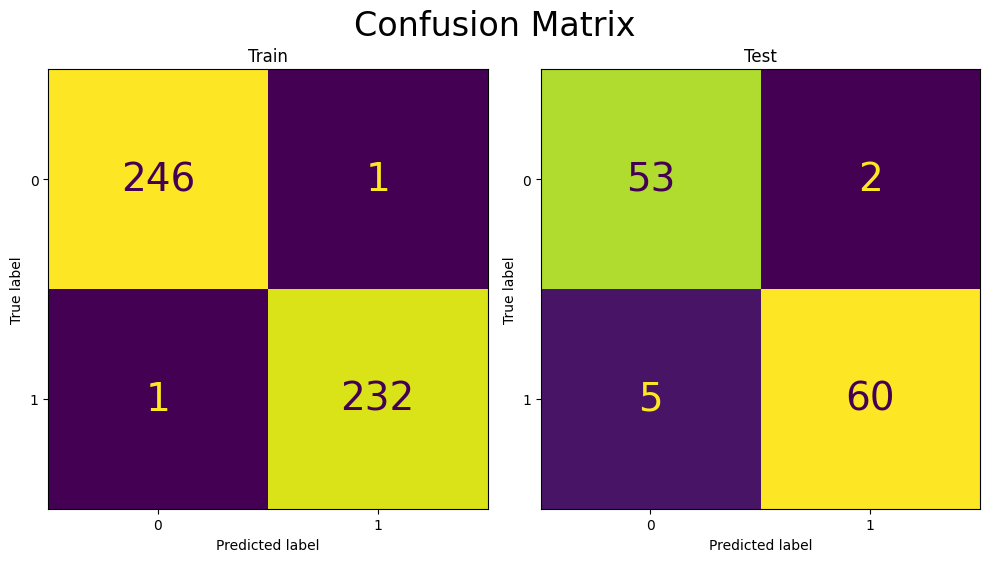

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


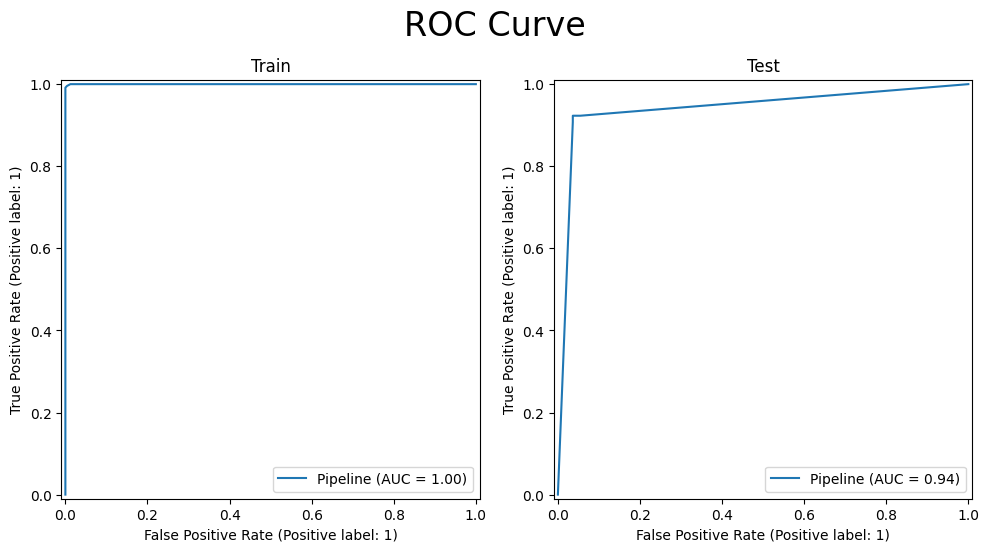

In [99]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

def plot_confusion_matrix(
    estimator, X_train, y_train, X_test, y_test, title="Confusion Matrix"
):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs = axs.flatten()

    ConfusionMatrixDisplay.from_estimator(
        estimator, X_train, y_train, ax=axs[0], text_kw={"fontsize": 28}, colorbar=False
    )
    ConfusionMatrixDisplay.from_estimator(
        estimator, X_test, y_test, ax=axs[1], text_kw={"fontsize": 28}, colorbar=False
    )

    axs[0].set_title("Train")
    axs[1].set_title("Test")
    plt.tight_layout()
    plt.suptitle(title, fontsize=24, y=0.78)
    plt.show()

def plot_ROC(
    estimator, X_train, y_train, X_test, y_test, title="ROC Curve"
):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs = axs.flatten()

    RocCurveDisplay.from_estimator(
        estimator, X_train, y_train, ax=axs[0]
    )
    RocCurveDisplay.from_estimator(
        estimator, X_test, y_test, ax=axs[1]
    )

    axs[0].set_title("Train")
    axs[1].set_title("Test")
    plt.tight_layout()
    plt.suptitle(title, fontsize=24, y=0.78)
    plt.show()

plot_confusion_matrix(best_model_pipeline, X_train, y_train, X_test, y_test)
plot_ROC(best_model_pipeline, X_train, y_train, X_test, y_test)

Partie 5 – Interprétabilité

11. Identifier les capteurs ayant le plus d’impact sur les prédictions.

In [73]:
%pip install Boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.9 MB/s eta 0:00:00


In [100]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from boruta import BorutaPy

class BorutaFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, output=False):
        self.estimator = estimator
        self.output = output

    def fit(self, X, y):
        self.feature_names_ = X.columns.tolist()
        self.selector = BorutaPy(
            estimator=self.estimator,
            n_estimators="auto",
            max_iter=10,
            random_state=random_state,
        )
        self.selector.fit(X.values, y)
        self._sklearn_is_fitted = True
        if self.output:
            self.show_ranking()

        return self

    def transform(self, X):
        check_is_fitted(self, attributes=["selector"])
        return X.iloc[:, self.selector.support_]

    def show_ranking(self):
        print("------Support and Ranking for each feature------")
        feature_info = [
            (self.selector.support_[i], self.selector.ranking_[i], feature)
            for i, feature in enumerate(self.feature_names_)
        ]
        feature_info.sort(key=lambda x: (x[1], x[2]))
        digit = len(str(len(self.feature_names_)))

        for support, ranking, feature in feature_info:
            status = "✅" if support else "❌"
            print(f"{status} Rank: {ranking:<{digit}} - {feature}")

pipeline_select_feature = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train)),
        (
            "feature_selection",
            BorutaFeatureSelector(
                estimator=RandomForestClassifier(), output=True
            ),
        ),
    ]
)

pipeline_select_feature.fit(X_train, y_train)

------Support and Ranking for each feature------
✅ Rank: 1  - sensor_10
✅ Rank: 1  - sensor_2
✅ Rank: 1  - sensor_3
✅ Rank: 1  - sensor_4
✅ Rank: 1  - sensor_5
✅ Rank: 1  - sensor_6
✅ Rank: 1  - sensor_7
✅ Rank: 1  - sensor_8
❌ Rank: 2  - sensor_9
❌ Rank: 3  - sensor_1


Pipeline(steps=[('washing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sensor_1', 'sensor_2',
                                                   'sensor_3', 'sensor_4',
                                                   'sensor_5', 'sensor_6',
                                                   'sensor_7', 'sensor_8',
                                                   'sensor_9', 'sensor_10'])],
                                   verbose_feature_names_out=False)),
                ('feature_selection',
                 BorutaFeatureSelector(estimator=RandomForestClassifier(n_estimators=42,
                                                                        random_state=RandomState(MT19937) at 0x7A061EAF5D40),
                                       output=True))])

In [ ]:
# Donc les capteurs ayant le plus d’impact sur les prédictions sont:
"""
✅ Rank: 1  - sensor_10
✅ Rank: 1  - sensor_2
✅ Rank: 1  - sensor_3
✅ Rank: 1  - sensor_4
✅ Rank: 1  - sensor_5
✅ Rank: 1  - sensor_6
✅ Rank: 1  - sensor_7
✅ Rank: 1  - sensor_8
"""

12. Evaluer les dépendances partielles des capteurs avec SHAP et PDP

PermutationExplainer explainer: 481it [06:12,  1.25it/s]
PermutationExplainer explainer: 121it [01:30,  1.15it/s]
<ipython-input-104-0793d0af77aa>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_train[:, :, 1], X_train, show=False)


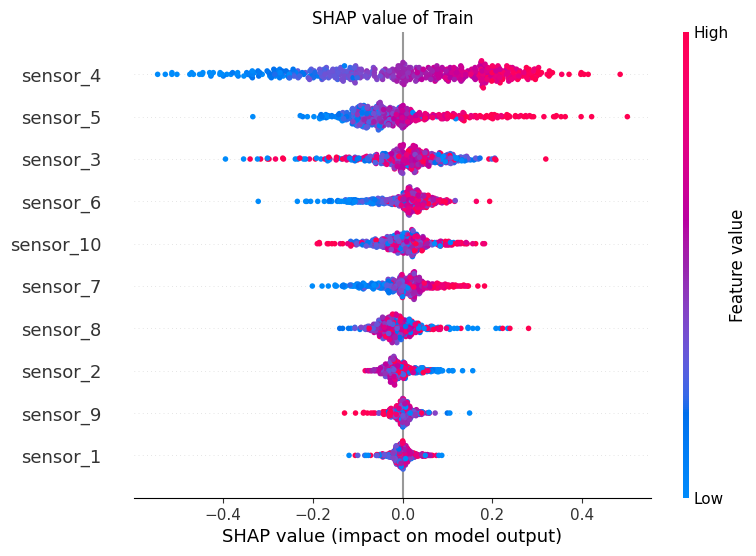

<ipython-input-104-0793d0af77aa>:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_test[:, :, 1], X_test, show=False)


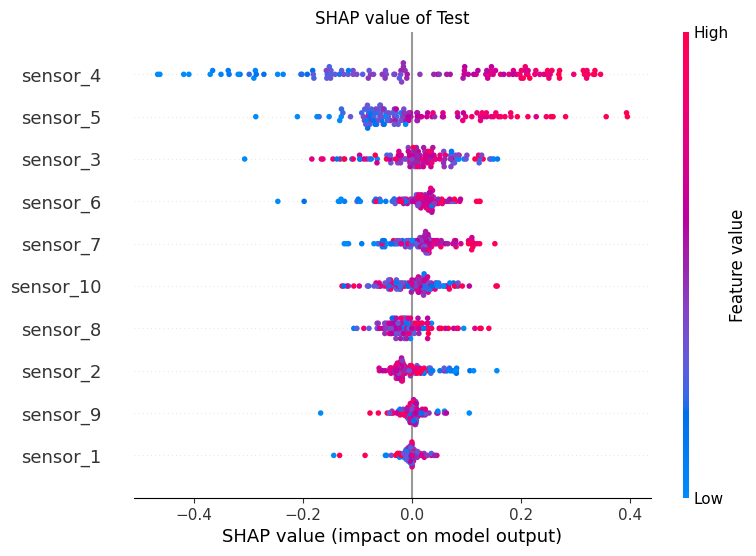

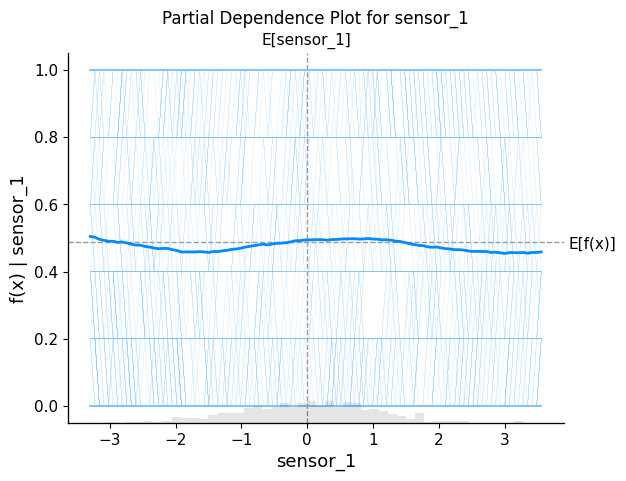

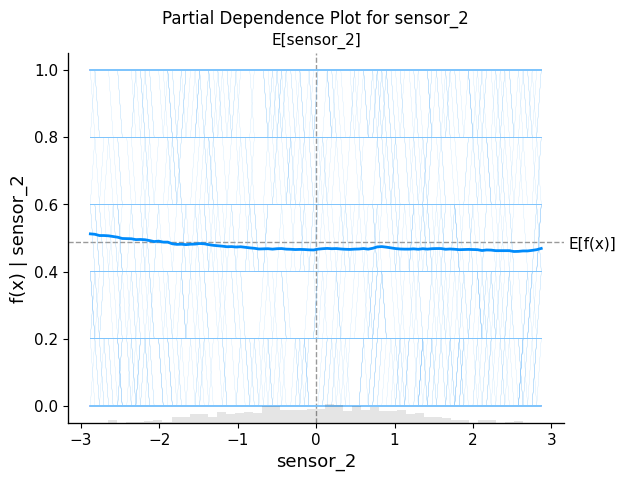

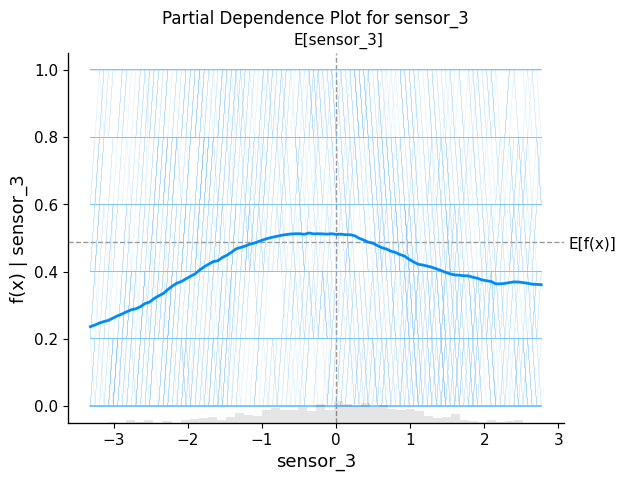

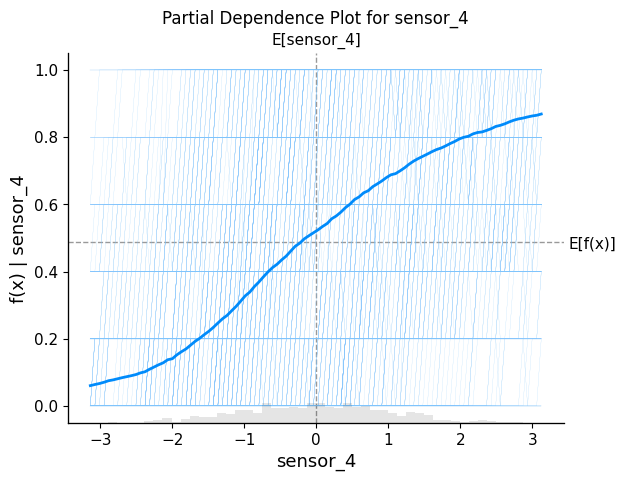

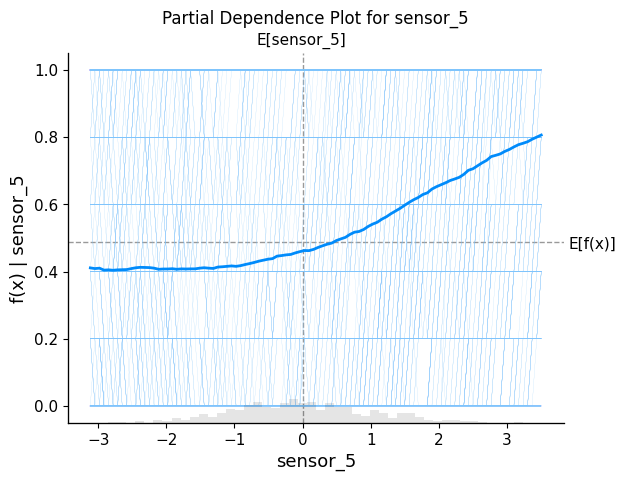

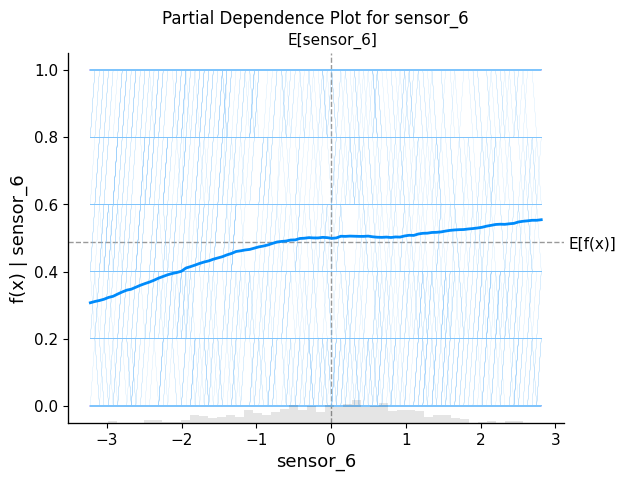

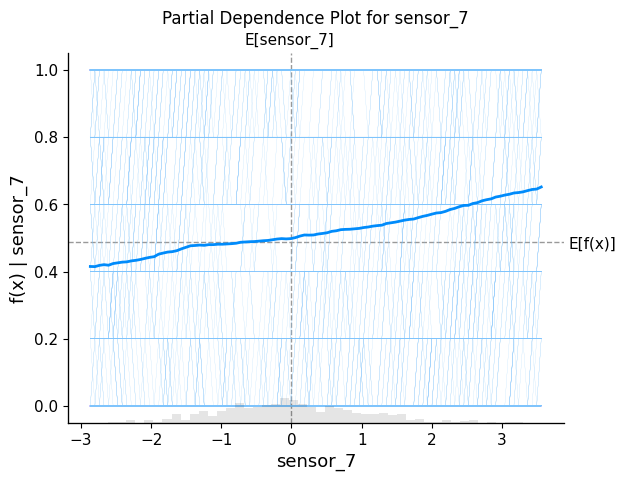

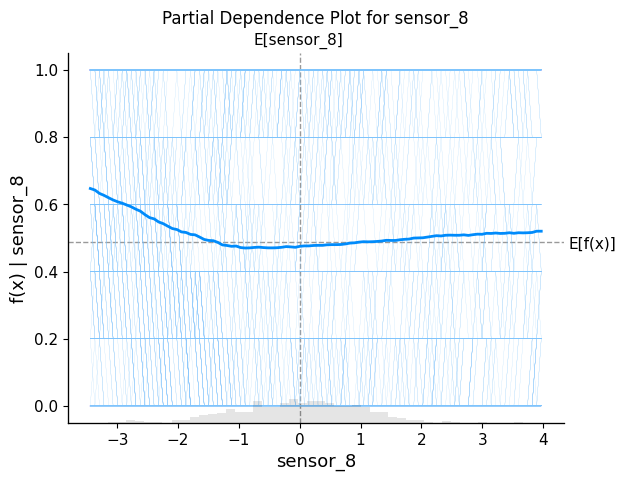

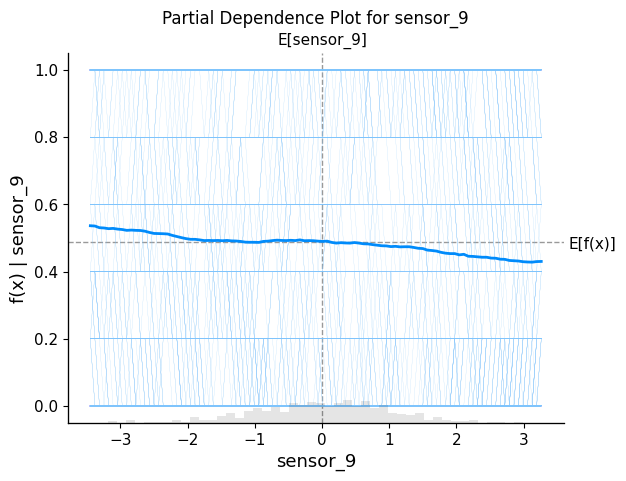

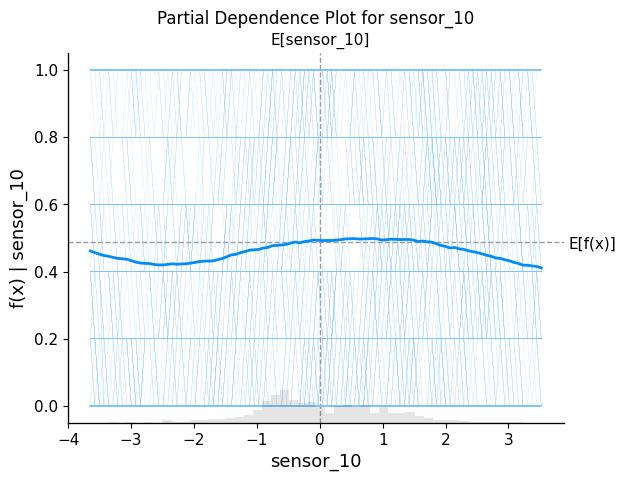

In [104]:
import shap

def plot_summary_plot(model, X_train, X_test):
    explainer = shap.explainers.Permutation(model.predict_proba, X_train)
    shap_values_train = explainer(X_train)
    shap_values_test = explainer(X_test)

    shap.summary_plot(shap_values_train[:, :, 1], X_train, show=False)
    plt.title("SHAP value of Train")
    plt.show()

    shap.summary_plot(shap_values_test[:, :, 1], X_test, show=False)
    plt.title("SHAP value of Test")
    plt.show()

def plot_ICE(model, X):
    for feature in X.columns.tolist():
        shap.plots.partial_dependence(  # Substitution for PartialDependenceDisplay.from_estimator()
            feature,
            lambda x: model.predict_proba(x)[:, 1],
            X,
            model_expected_value=True,
            feature_expected_value=True,
            ice=True,
            show=False,
        )  # Does not support ax
        plt.title(f"Partial Dependence Plot for {feature}")
        plt.show()

pipeline_full = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train)),
        ("model", KNeighborsClassifier())
    ]
)

pipeline_full.fit(X_train, y_train)

model_full = pipeline_full.named_steps["model"]
X_train_washed = pipeline_full.named_steps["washing"].transform(X_train)
X_test_washed = pipeline_full.named_steps["washing"].transform(X_test)

plot_summary_plot(
    model=model_full,
    X_train=X_train_washed,
    X_test=X_test_washed,
)

plot_ICE(model_full,X_train_washed)

12. Analyser les erreurs de classification : quels types d’exemples sont mal prédits ?

In [ ]:
# Il n'y a pas d'exemples mal prédits.

Partie 6 – Synthèse finale

13. Présenter un court bilan rédigé :
- Quel est le modèle le plus performant ?
- Quelles variables (capteurs) sont les plus influentes ?
- Quelle pourrait être l’interprétation métier du problème ?

In [103]:
# Mise en garde: Les param_grid ne sont pas bien construits parce que en utilisant Umap et un seed spécifié, n_jobs est limité à 1.
# Donc j'ai déduit la pluspart des hyperparamètres pour un résultat plus vite.
# Donc le résultat de l'optimization des hyperparamètres n'est pas le plus ideal.

# Les modèles les plus performants sont régression logistique, KNN et SVM,
# qui ont la meilleur F1-score sur l'entrainement et le test mais petit différence entre l'entrainement et le test

# Les capteurs les plus influentes sont:
"""
✅ Rank: 1  - sensor_10
✅ Rank: 1  - sensor_2
✅ Rank: 1  - sensor_3
✅ Rank: 1  - sensor_4
✅ Rank: 1  - sensor_5
✅ Rank: 1  - sensor_6
✅ Rank: 1  - sensor_7
✅ Rank: 1  - sensor_8
"""
# Selon les PDP plots, le capteur 4 est le plus influentes.

# Interprétation métier:
# Il y a potentiellement 2 capteurs qui n'a pas influence important sur le status, donc on peut déduire ces 2 capteurs pour déduire le coût.